# Example patient population and pathway timings

This notebook creates the stroke pathway timings and patient population that are used in various examples in this online book. They are used for setting up the times from stroke onset to treatment and for combining cohorts of patients where the separate cohorts have different stroke types and treatment(s) given. 

These data are used in:
+ The outcome matrix calculations (patient population only).
+ The generic geography results.
+ The England and Wales examples.

## Plain English summary

When we calculate results that apply to patients with a mix of stroke types and given a mix of treatments, we want to make sure that our mix of patients is representative of the real world. This makes it as fair as possible when we make generalisations about a whole population of patients.

For example, some patients would benefit from thrombectomy but this surgery is not available at all stroke units. When these patients go to a stroke unit that does offer thrombolysis but doesn't offer thrombectomy, there is a delay in being transferred to the thrombectomy unit and then extra travel time. These delays could have been avoided had the patient been _redirected_ and travelled directly to the thrombectomy unit. There are fewer thrombectomy units than thrombolysis units in the UK so generally speaking this redirection saves time for treatment with thrombectomy (by removing the transfer delay) but adds time for treatment with thrombolysis (by increasing the initial travel time to hospital).
In this example, when we want to see whether redirection is beneficial on average across all stroke patients, we have to see if the benefit to only a few patients who need thrombectomy outweighs the disadvantage to many patients who do not need thrombectomy. To do this accurately, we need to know the breakdown of stroke types in the population.

These patient proportions are reasonable assumptions of the true real-life patient population rather than definitive facts.

We can calculate the pathway times and the patient proportions once in this notebook and then save the results. Then all of the other examples in this online book can load in the exact same data every time and we can compare all of the results fairly.

## Aims

Create a list of the stroke pathway timings and patient populations and save the results to file for future use.

The pathway times are arbitrary, based on estimated best-case scenarios, and include:
+ time from stroke onset to ambulance arrival
+ time from arrival at stroke unit to treatment with IVT (time to needle)
+ time from arrival at stroke unit to treatment with MT (time to puncture)
+ time from arrival at first stroke unit to departure from first stroke unit when a transfer is required.

The patient population is informed by the SSNAP data used in SAMueL-1 and includes proportions of each of these cohorts:
+ haemorrhagic
+ nLVO with no treatment
+ nLVO with IVT
+ LVO with no treatment
+ LVO with IVT only
+ LVO with MT only
+ LVO with both IVT and MT


## Methods

__Pathway:__ The pathway times are chosen based on estimated best-case scenarios.

__Patients:__ The patient population is built using the statistics from the SSNAP data used in SAMueL-1 for patients who arrive at hospital within six hours of stroke onset:
+ [Breakdown of patients into haemorrhagic / NIHSS 0 to 10 / NIHSS 11 and higher](https://samuel-book.github.io/samuel-1/descriptive_stats/10_using_nihss_10_for_lvo.html)
+ [Breakdown of proportion of thrombolysed patients by NIHSS score](https://samuel-book.github.io/samuel-1/descriptive_stats/01a_descriptive_nihss_cutoff.html)

We use the NIHSS score to decide whether patients had an LVO or an nLVO. When NIHSS is 11 or higher, we assign LVO. When NIHSS is 10 or under, we assign nLVO.

We combine these statistics with targets for how many patients should receive treatment:
+ 20% of all patients should receive IVT
+ 10% of all patients should receive MT
+ 85% of patients who receive MT should have previously received IVT

We can then define a proportion of the population who has each stroke type and each treatment and adjust the proportions to match the existing statistics and the treatment rate targets.

## Notebook setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os

from numpy import isclose  # for checking proportions vs targets

Save output files to this directory:

In [2]:
dir_output = 'output'
dir_images = 'images'

Use the following colours in the pie charts:

In [3]:
colour_dict = {
    'haemorrhagic': 'grey',
    'lvo': '#0072b2',                # seaborn colorblind blue
    'nlvo': '#d55e00',               # seaborn colorblind orange
    'lvo_no_treatment': '#00517f',   # seaborn colorblind blue darker
    'lvo_ivt_only': '#0072b2',       # seaborn colorblind blue
    'lvo_ivt_mt': '#0093e5',         # seaborn colorblind blue lighter
    'lvo_mt_only': '#00b3ff',        # seaborn colorblind blue lighter 2
    'nlvo_no_treatment': '#d55e00',  # seaborn colorblind orange
    'nlvo_ivt': '#ff7400',           # seaborn colorblind orange lighter
}

## Pathway timings

In [1]:
pathway_times = {
    'onset_to_ambulance_arrival': 60,
    'arrival_to_ivt': 30,
    'arrival_to_mt': 90,
    'net_operational_delay_to_mt_for_transfer': 60
}

Save to file:

In [2]:
pd.Series(pathway_times).to_csv(os.path.join(dir_output, 'pathway_times.csv'))

SyntaxError: unexpected EOF while parsing (2500097932.py, line 1)

## Stroke types

For patients arriving within 6 hours of stroke onset (from [SAMueL-1 book](https://samuel-book.github.io/samuel-1/descriptive_stats/10_using_nihss_10_for_lvo.html)):
+ 13.6% have haemorrhagic stroke
+ The remaining strokes are ischaemic. Of these:
  + 29.5% are LVO
  + 70.5% are nLVO

In [4]:
stroke_type_proportions = {
    'haemorrhagic': 0.136,
    'lvo': 0.295 * (1 - 0.136),
    'nlvo': 0.705 * (1 - 0.136)
}

Display the proportions:

In [5]:
pd.Series(stroke_type_proportions)

haemorrhagic    0.13600
lvo             0.25488
nlvo            0.60912
dtype: float64

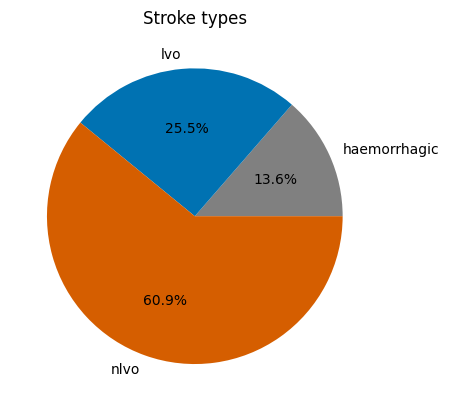

In [6]:
plt.pie(
    stroke_type_proportions.values(),
    labels=stroke_type_proportions.keys(),
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in stroke_type_proportions.keys()]
    )
plt.title('Stroke types')
plt.savefig(os.path.join(dir_images, 'props_stroke_types.png'), bbox_inches='tight')
plt.show()

## Treatment

Fix the MT value first because this depends only on LVO.

Patients with NIHSS>10 account for 46.7% of all thrombolysed patients ([from SAMueL-1](https://samuel-book.github.io/samuel-1/descriptive_stats/01a_descriptive_nihss_cutoff.html)).

Multiply this proportion by the target IVT rate:

> 20% $\times$ 46.7% = Proportion of all patients with LVO and IVT

And assign the remaining patients to nLVO:

> 20% $\times$ (100% - 46.7%) = Proportion of all patients with nLVO and IVT

Then account for the fact that most LVO patients receiving MT also receive IVT.

In [7]:
target_ivt = 0.2
target_mt = 0.1
prop_mt_previously_ivt = 0.85

prop_ivt_lvo = 0.467

### nLVO

In [8]:
prop_nlvo_ivt = target_ivt * (1.0 - prop_ivt_lvo) / stroke_type_proportions['nlvo']

Display the proportions:

In [9]:
nlvo_proportions = {
    'nlvo_no_treatment': (1.0 - prop_nlvo_ivt),
    'nlvo_ivt': prop_nlvo_ivt,
}

In [10]:
pd.Series(nlvo_proportions)

nlvo_no_treatment    0.824993
nlvo_ivt             0.175007
dtype: float64

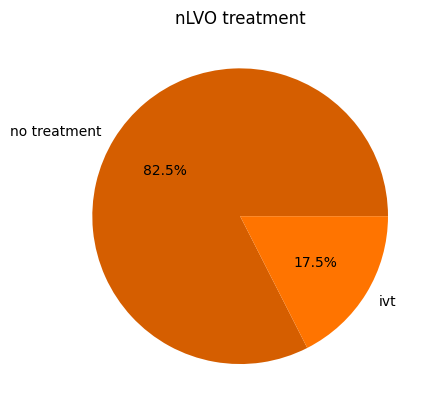

In [11]:
plt.pie(
    nlvo_proportions.values(),
    labels=[c.split('nlvo_')[1].replace('_', ' ') for c in nlvo_proportions.keys()],
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in nlvo_proportions.keys()]
    )
plt.title('nLVO treatment')
plt.savefig(os.path.join(dir_images, 'props_nlvo.png'), bbox_inches='tight')
plt.show()

### LVO

Only LVO is treated with MT, so to hit the target value of 10% we need:

> Proportion LVO $\times$ Proportion of LVO treated with MT = 10%

Rearranging:

> Proportion of LVO treated with MT = 10% / Proportion LVO

In [12]:
prop_lvo_mt = target_mt / stroke_type_proportions['lvo']

Then set the overlap between IVT and MT for LVO patients:

In [13]:
prop_lvo_ivtmt = prop_lvo_mt * prop_mt_previously_ivt

Find the LVO patients treated with IVT:

In [14]:
prop_lvo_ivt = (target_ivt * prop_ivt_lvo) / stroke_type_proportions['lvo']

Compare values:

In [15]:
print(prop_lvo_mt, prop_lvo_ivtmt, prop_lvo_ivt)

0.39234149403640933 0.33349026993094794 0.3664469554300063


Subtract the overlap:

In [16]:
prop_lvo_mtonly = prop_lvo_mt - prop_lvo_ivtmt
prop_lvo_ivtonly = prop_lvo_ivt - prop_lvo_ivtmt

Display the LVO proportions:

In [17]:
lvo_proportions = {
    'lvo_no_treatment': (1.0 - prop_lvo_mt - prop_lvo_ivtonly),
    'lvo_ivt_only': prop_lvo_ivtonly,
    'lvo_ivt_mt': prop_lvo_ivtmt,
    'lvo_mt_only': prop_lvo_mtonly,
}

In [18]:
pd.Series(lvo_proportions)

lvo_no_treatment    0.574702
lvo_ivt_only        0.032957
lvo_ivt_mt          0.333490
lvo_mt_only         0.058851
dtype: float64

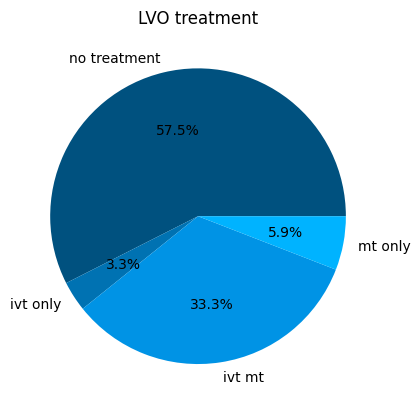

In [19]:
plt.pie(
    lvo_proportions.values(),
    labels=[c.split('lvo_')[1].replace('_', ' ') for c in lvo_proportions.keys()],
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in lvo_proportions.keys()]
    )
plt.title('LVO treatment')
plt.savefig(os.path.join(dir_images, 'props_lvo.png'), bbox_inches='tight')
plt.show()

## Whole population breakdown

In [20]:
pop_proportions = {
    'haemorrhagic': stroke_type_proportions['haemorrhagic'],
    'lvo_no_treatment': stroke_type_proportions['lvo'] * lvo_proportions['lvo_no_treatment'],
    'lvo_ivt_only': stroke_type_proportions['lvo'] * lvo_proportions['lvo_ivt_only'],
    'lvo_ivt_mt': stroke_type_proportions['lvo'] * lvo_proportions['lvo_ivt_mt'],
    'lvo_mt_only': stroke_type_proportions['lvo'] * lvo_proportions['lvo_mt_only'],
    'nlvo_no_treatment': stroke_type_proportions['nlvo'] * nlvo_proportions['nlvo_no_treatment'],
    'nlvo_ivt': stroke_type_proportions['nlvo'] * nlvo_proportions['nlvo_ivt'],
}

# Round values to 5 decimal places:
for key, value in pop_proportions.items():
    pop_proportions[key] = round(value, 5)

In [21]:
pd.Series(pop_proportions)

haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
dtype: float64

### Sanity checks

Do all proportions add up to 1?

In [22]:
pd.Series(pop_proportions).sum()

1.0

Check that the treated proportions match the targets:

In [23]:
prop_ivt = 0.0
prop_mt = 0.0

for key, value in pop_proportions.items():
    if 'ivt' in key:
        prop_ivt += value
    if 'mt' in key:
        prop_mt += value

In [24]:
print('IVT:', prop_ivt, isclose(prop_ivt, target_ivt))
print('MT:', prop_mt, isclose(prop_mt, target_mt))

IVT: 0.2 True
MT: 0.1 True


Check that the stroke type subgroups add up to the total stroke type sizes:

In [25]:
prop_lvo = 0.0
prop_nlvo = 0.0

for key, value in pop_proportions.items():
    if 'nlvo' in key:
        prop_nlvo += value
    elif 'lvo' in key:
        prop_lvo += value

In [26]:
print('LVO:', prop_lvo, isclose(prop_lvo, stroke_type_proportions['lvo']))
print('nLVO:', prop_nlvo, isclose(prop_nlvo, stroke_type_proportions['nlvo']))

LVO: 0.25488 True
nLVO: 0.60912 True


### Plot

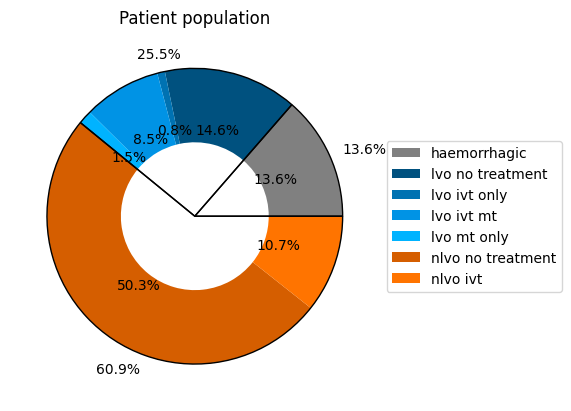

In [27]:
fig, ax = plt.subplots()

# Draw each cohort/treatment subgroup in a different colour
# and write the size on the wedge.
wedges, texts, autotexts = ax.pie(
    pop_proportions.values(),
    autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=0.5),
    colors=[colour_dict[c] for c in pop_proportions.keys()]
    )

# Outline LVO, nLVO and haemorrhagic sections
# and add labels outside each section.
ax.pie(
    stroke_type_proportions.values(),
    labels=[f'{c:.1%}' for c in stroke_type_proportions.values()],
    # autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=1.0, edgecolor='k'),
    colors=['None'] * len(stroke_type_proportions),
    )

ax.legend(
    wedges, [c.replace('_', ' ') for c in pop_proportions.keys()],
    bbox_to_anchor=[1.0, 0.5], loc='center left'
)

plt.title('Patient population')
plt.savefig(os.path.join(dir_images, 'props_all.png'), bbox_inches='tight')
plt.show()

### Save population proportions to file

In [28]:
pd.Series(pop_proportions).to_csv(os.path.join(dir_output, 'patient_proportions.csv'), header=False)

## Exclude haemorrhagic stroke

In [29]:
pop_ischaemic = dict()
prop_ischaemic = 1.0 - pop_proportions['haemorrhagic']

for key, value in pop_proportions.items():
    if 'haemo' not in key:
        pop_ischaemic[key] = value / prop_ischaemic

In [30]:
pd.Series(pop_ischaemic)

lvo_no_treatment     0.169537
lvo_ivt_only         0.009722
lvo_ivt_mt           0.098380
lvo_mt_only          0.017361
nlvo_no_treatment    0.581620
nlvo_ivt             0.123380
dtype: float64

In [31]:
pd.Series(pop_ischaemic).sum()

1.0

In [32]:
ischaemic_proportions = dict()

for key, value in stroke_type_proportions.items():
    if 'haemo' not in key:
        ischaemic_proportions[key] = value / prop_ischaemic

In [33]:
pd.Series(ischaemic_proportions)

lvo     0.295
nlvo    0.705
dtype: float64

In [34]:
pd.Series(ischaemic_proportions).sum()

1.0

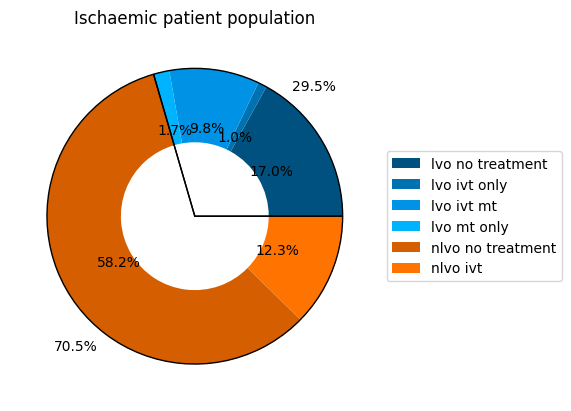

In [35]:
fig, ax = plt.subplots()

# Draw each cohort/treatment subgroup in a different colour
# and write the size on the wedge.
wedges, texts, autotexts = ax.pie(
    pop_ischaemic.values(),
    autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=0.5),
    colors=[colour_dict[c] for c in pop_ischaemic.keys()]
    )

# Outline LVO, nLVO and haemorrhagic sections
# and add labels outside each section.
ax.pie(
    ischaemic_proportions.values(),
    labels=[f'{c:.1%}' for c in ischaemic_proportions.values()],
    # autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=1.0, edgecolor='k'),
    colors=['None'] * len(ischaemic_proportions),
    )

ax.legend(
    wedges, [c.replace('_', ' ') for c in pop_ischaemic.keys()],
    bbox_to_anchor=[1.0, 0.5], loc='center left'
)

plt.title('Ischaemic patient population')
plt.savefig(os.path.join(dir_images, 'props_ischaemic.png'), bbox_inches='tight')
plt.show()

## Conclusion

The data in the pathway times dictionary and in the patient proportions dictionary for the full population including haemorrhagic stroke have been saved to file and can now be used across multiple projects.

The final patient proportions are in this pie chart:

![Pie chart of the stroke type and treatment proportions.]('images/props_all.png')

The saved data is imported in this way:

In [5]:
fixed_times = pd.read_csv(
    os.path.join('..', 'england_wales', 'output', 'pathway_times.csv'),
    index_col=0, header=None).squeeze()

fixed_times

0
onset_to_ambulance_arrival                  60
arrival_to_ivt                              30
arrival_to_mt                               90
net_operational_delay_to_mt_for_transfer    60
Name: 1, dtype: int64

In [6]:
patient_proportions = pd.read_csv(
    os.path.join('..', 'england_wales', 'output', 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

patient_proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64